# KNN

## 调参

- n_neighbors：取邻近点的个数
- weights：是否考虑权重。uniform：一致的权重；distance：距离的倒数作为权重
- p：距离计算方法，只有当weight=distance的时候，p才有意义

In [79]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

train = pd.read_csv('train.csv', encoding='gbk')
test = pd.read_csv('test.csv', encoding='gbk')

X_train, y_train = train.drop(['标的状态.还清'], axis=1), train['标的状态.还清']
X_test, y_test = test.drop(['标的状态.还清'], axis=1), test['标的状态.还清']

params_grid = [
    {
        'weights':['uniform'],
        'n_neighbors':[i for i in range(5, 15)]
    },
    {
        'weights':['distance'],
        'n_neighbors':[i for i in range(5, 15)],
        'p':[i for i in range(1, 6)]
    }
]

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, params_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)
optimized_knn = grid_search.fit(X_train, y_train)
print('Train accuracy: %.5f' % optimized_knn.best_score_)  # validation accuracy best
print(optimized_knn.best_params_)

# 看在测试集上的效果
best_knn = optimized_knn.best_estimator_
best_knn.fit(X_train, y_train)
print('Test accuracy: %.5f' % best_knn.score(X_test, y_test))

Train accuracy: 0.90893
{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Test accuracy: 0.91403


## 结果可视化

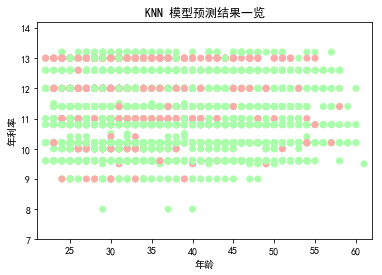

In [64]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False

#确认训练集的边界
x_min, x_max = X_test['年龄'].min(), X_test['年龄'].max()
y_min, y_max = X_test['年利率'].min(), X_test['年利率'].max()

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA']) #给不同区域赋以颜色

Z = best_knn.predict(X_test)
Z = Z.reshape(X_test['年龄'].shape)
plt.scatter(X_test['年龄'], X_test['年利率'], c=Z, cmap=cmap_light)
plt.xlim(x_min-1, x_max+1)
plt.ylim(y_min-1, y_max+1)
plt.xlabel(u'年龄')
plt.ylabel(u'年利率')    # 可以使用中文，但需要导入一些库即字体
plt.title(u'KNN 模型预测结果一览')
plt.show()

# RandomForest

[参考](https://blog.csdn.net/wjwfighting/article/details/82081204)

1. bagging 框架参数

    - n_estimators: 也就是弱学习器的最大迭代次数，或者说最大的弱学习器的个数。一般来说n_estimators太小，容易欠拟合，n_estimators太大，计算量会太大，并且n_estimators到一定的数量后，再增大n_estimators获得的模型提升会很小，所以一般选择一个适中的数值。默认是100。

    - oob_score :即是否采用袋外样本来评估模型的好坏。默认识False。个人推荐设置为True，因为袋外分数反应了一个模型拟合后的泛化能力。

    - criterion: 即CART树做划分时对特征的评价标准。分类模型和回归模型的损失函数是不一样的。分类RF对应的CART分类树默认是基尼系数gini,另一个可选择的标准是信息增益。回归RF对应的CART回归树默认是均方差mse，另一个可以选择的标准是绝对值差mae。一般来说选择默认的标准就已经很好的。

2. 决策树参数

    - RF划分时考虑的最大特征数 `max_features`: 可以使用很多种类型的值，默认是"auto",意味着划分时最多考虑N−−√N个特征；如果是"log2"意味着划分时最多考虑log2Nlog2N个特征；如果是"sqrt"或者"auto"意味着划分时最多考虑N−−√N个特征。如果是整数，代表考虑的特征绝对数。如果是浮点数，代表考虑特征百分比，即考虑（百分比xN）取整后的特征数。其中N为样本总特征数。一般我们用默认的"auto"就可以了，如果特征数非常多，我们可以灵活使用刚才描述的其他取值来控制划分时考虑的最大特征数，以控制决策树的生成时间。

    - 决策树最大深度 `max_depth`: 默认可以不输入，如果不输入的话，决策树在建立子树的时候不会限制子树的深度。一般来说，数据少或者特征少的时候可以不管这个值。如果模型样本量多，特征也多的情况下，推荐限制这个最大深度，具体的取值取决于数据的分布。常用的可以取值10-100之间。

    - 内部节点再划分所需最小样本数 `min_samples_split`: 这个值限制了子树继续划分的条件，如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分。 默认是2.如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

    - 叶子节点最少样本数 `min_samples_leaf`: 这个值限制了叶子节点最少的样本数，如果某叶子节点数目小于样本数，则会和兄弟节点一起被剪枝。 默认是1,可以输入最少的样本数的整数，或者最少样本数占样本总数的百分比。如果样本量不大，不需要管这个值。如果样本量数量级非常大，则推荐增大这个值。

![](https://img2018.cnblogs.com/blog/784325/201811/784325-20181119195216287-163268358.png)

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import cross_validation, metrics

import matplotlib.pylab as plt
%matplotlib inline

train = pd.read_csv('train.csv', encoding='gbk')
test = pd.read_csv('test.csv', encoding='gbk')

X_train, y_train = train.drop(['标的状态.还清'], axis=1), train['标的状态.还清']
X_test, y_test = test.drop(['标的状态.还清'], axis=1), test['标的状态.还清']

## n_estimators

In [5]:
cv_params = {'n_estimators': range(95,100,1)}
other_params = {'min_samples_split': 100, 'min_samples_leaf': 20, 'max_depth': 8,
                'max_features': 'sqrt' , 'random_state': 10}

model = RandomForestClassifier(**other_params)
optimized_rf = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=4)
optimized_rf.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_rf.param_grid))
print('参数的最佳取值：{0}'.format(optimized_rf.best_params_))
print('最佳模型得分:{0}'.format(optimized_rf.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    3.9s finished


参数网格：{'n_estimators': range(95, 100)}
参数的最佳取值：{'n_estimators': 96}
最佳模型得分:0.9988861983632341


## min_samples_split 及 max_depth

In [6]:
cv_params = {'max_depth':range(10,20,1), 'min_samples_split':range(40,45,1)}
other_params = {'n_estimators': 96, 'min_samples_split': 100, 'min_samples_leaf': 20, 
                'max_depth': 8, 'max_features': 'sqrt' , 'random_state': 10}

model = RandomForestClassifier(**other_params)
optimized_rf = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=4)
optimized_rf.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_rf.param_grid))
print('参数的最佳取值：{0}'.format(optimized_rf.best_params_))
print('最佳模型得分:{0}'.format(optimized_rf.best_score_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   42.8s finished


参数网格：{'max_depth': range(10, 20), 'min_samples_split': range(40, 45)}
参数的最佳取值：{'max_depth': 17, 'min_samples_split': 41}
最佳模型得分:0.9990963535850768


## min_samples_split 和 min_samples_leaf

In [7]:
cv_params = {'min_samples_leaf': range(1,10,1), 'min_samples_split':range(40,45,1)}
other_params = {'n_estimators': 96, 'min_samples_split': 41, 'min_samples_leaf': 20, 
                'max_depth': 17, 'max_features': 'sqrt' , 'random_state': 10}

model = RandomForestClassifier(**other_params)
optimized_rf = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=4)
optimized_rf.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_rf.param_grid))
print('参数的最佳取值：{0}'.format(optimized_rf.best_params_))
print('最佳模型得分:{0}'.format(optimized_rf.best_score_))

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done 225 out of 225 | elapsed:   38.2s finished


参数网格：{'min_samples_leaf': range(1, 10), 'min_samples_split': range(40, 45)}
参数的最佳取值：{'min_samples_leaf': 1, 'min_samples_split': 43}
最佳模型得分:0.9993719699799197


## max_features

In [80]:
cv_params = {'max_features': range(8,15,1)}
other_params = {'n_estimators': 97, 'min_samples_split': 43, 'min_samples_leaf': 1, 
                'max_depth': 14, 'max_features': 'sqrt' , 'random_state': 10}

model = RandomForestClassifier(**other_params)
optimized_rf = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
optimized_rf.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_rf.param_grid))
print('参数的最佳取值：{0}'.format(optimized_rf.best_params_))
print('最佳模型得分:{0}'.format(optimized_rf.best_score_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.4s finished


参数网格：{'max_features': range(8, 15)}
参数的最佳取值：{'max_features': 13}
最佳模型得分:0.9891435464414958


In [81]:
# 看在测试集上的效果
best_rf = optimized_rf.best_estimator_
best_rf.fit(X_train, y_train)
print('Test accuracy: %.5f' % best_rf.score(X_test, y_test))

Test accuracy: 0.98668


## 每颗决策树展示

In [38]:
Estimators = best_rf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
             max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=41,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1165313289, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
             max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=41,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1283169405, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
             max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=41,
             min_weight_fraction_l

In [7]:
#from IPython.display import Image
#from sklearn import tree
#import pydotplus
#import os 
#
#Estimators = best_rf.estimators_
#for index, model in enumerate(Estimators):
#    filename = 'result_' + str(index) + '.pdf'
#    dot_data = tree.export_graphviz(model , out_file=None,
#                                    feature_names=X_test.columns,
#                                    class_names=y_test.name,
#                                    filled=True, rounded=True,
#                                    special_characters=True)
#    graph = pydotplus.graph_from_dot_data(dot_data)
#    # 使用ipython的终端jupyter notebook显示。
#    Image(graph.create_png())
#    graph.write_pdf(filename)

## 变量重要性展示

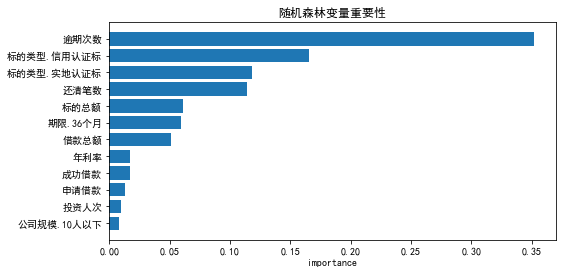

In [59]:
#-*- coding: utf-8 -*-
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False

importances = best_rf.feature_importances_
features = X_test.columns[importances>0.005]
importances = importances[importances>0.005]

indices = np.argsort(importances)
y_pos = np.arange(len(indices))

# 横向柱状图
plt.figure(figsize=(8,4))
plt.barh(y_pos, importances[indices], align='center')
plt.yticks(y_pos, [features[i] for i in indices])
plt.xlabel('importance')
plt.title('随机森林变量重要性')
plt.show()

# XGBOOST

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd

train = pd.read_csv('train.csv', encoding='gbk')
test = pd.read_csv('test.csv', encoding='gbk')

X_train, y_train = train.drop(['标的状态.还清'], axis=1), train['标的状态.还清']
X_test, y_test = test.drop(['标的状态.还清'], axis=1), test['标的状态.还清']

## n_estimators

In [12]:
cv_params = {'n_estimators': range(95,100,1)}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_GBM.param_grid))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   20.2s finished


参数网格：{'n_estimators': range(95, 100)}
参数的最佳取值：{'n_estimators': 98}
最佳模型得分:0.999756511073643


## min_child_weight 及 max_depth

In [16]:
cv_params = {'max_depth': range(4,6), 'min_child_weight': range(1,3)}
other_params = {'learning_rate': 0.1, 'n_estimators': 98, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_GBM.param_grid))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   14.2s finished


参数网格：{'max_depth': range(4, 6), 'min_child_weight': range(1, 3)}
参数的最佳取值：{'max_depth': 5, 'min_child_weight': 1}
最佳模型得分:0.999756511073643


## gamma

In [17]:
cv_params = {'gamma': [i / 10.0 for i in range(0,5)] }
other_params = {'learning_rate': 0.1, 'n_estimators': 98, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_GBM.param_grid))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   19.3s finished


参数网格：{'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}
参数的最佳取值：{'gamma': 0.0}
最佳模型得分:0.999756511073643


## subsample 和 colsample_bytree

In [19]:
cv_params = {'subsample': [i / 100.0 for i in range(60,75,5)],
             'colsample_bytree': [i / 100.0 for i in range(75,90,5)] }
other_params = {'learning_rate': 0.1, 'n_estimators': 98, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_GBM.param_grid))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   36.7s finished


参数网格：{'subsample': [0.6, 0.65, 0.7], 'colsample_bytree': [0.75, 0.8, 0.85]}
参数的最佳取值：{'colsample_bytree': 0.85, 'subsample': 0.65}
最佳模型得分:0.9997567139424594


## reg_alpha 和 reg_lambda

In [20]:
cv_params = {'reg_alpha': [0, 0.01, 0.02, 0.03], 'reg_lambda': [0.3, 0.5, 0.7]}
other_params = {'learning_rate': 0.1, 'n_estimators': 98, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                'subsample': 0.65, 'colsample_bytree': 0.85, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}

model = XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_GBM.param_grid))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   48.6s finished


参数网格：{'reg_alpha': [0, 0.01, 0.02, 0.03], 'reg_lambda': [0.3, 0.5, 0.7]}
参数的最佳取值：{'reg_alpha': 0, 'reg_lambda': 0.5}
最佳模型得分:0.9997746964945298


### 重新校准 n_estimators

In [21]:
cv_params = {'n_estimators': range(80,95,1)}
other_params = {'learning_rate': 0.1, 'n_estimators': 98, 'max_depth': 7, 'min_child_weight': 2, 'seed': 0,
                'subsample': 0.65, 'colsample_bytree': 0.85, 'gamma': 0.2, 'reg_alpha': 0, 'reg_lambda': 0.5}

model = XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_GBM.param_grid))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   32.1s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:  1.0min finished


参数网格：{'n_estimators': range(80, 95)}
参数的最佳取值：{'n_estimators': 86}
最佳模型得分:0.9997607503814229


## learning_rate

In [82]:
cv_params = {'learning_rate': [0.05, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 86, 'max_depth': 7, 'min_child_weight': 2, 'seed': 0,
                'subsample': 0.65, 'colsample_bytree': 0.85, 'gamma': 0.2, 'reg_alpha': 0, 'reg_lambda': 0.5}

model = XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(X_train, y_train)
print('参数网格：{0}'.format(optimized_GBM.param_grid))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   19.5s finished


参数网格：{'learning_rate': [0.05, 0.1, 0.2]}
参数的最佳取值：{'learning_rate': 0.05}
最佳模型得分:0.9931644551668677


In [83]:
# 看在测试集上的效果
best_GBM = optimized_GBM.best_estimator_
best_GBM.fit(X_train, y_train)
print('Test accuracy: %.5f' % best_GBM.score(X_test, y_test))

Test accuracy: 0.99014


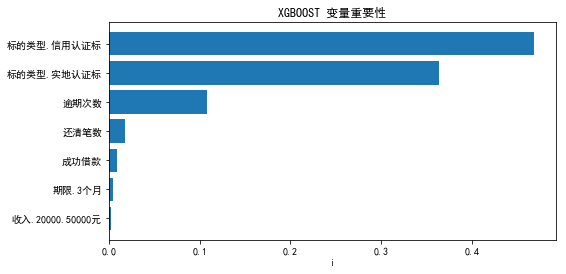

In [66]:
#-*- coding: utf-8 -*-
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False

importances = best_GBM.feature_importances_
features = X_test.columns[importances>0.0015]
importances = importances[importances>0.0015]

indices = np.argsort(importances)
y_pos = np.arange(len(indices))

# 横向柱状图
plt.figure(figsize=(8,4))
plt.barh(y_pos, importances[indices], align='center')
plt.yticks(y_pos, [features[i] for i in indices])
plt.xlabel('i')
plt.title('XGBOOST 变量重要性')
plt.show()

# Stacking

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')

train = pd.read_csv('train.csv', encoding='gbk')
test = pd.read_csv('test.csv', encoding='gbk')

X_train, y_train = train.drop(['标的状态.还清'], axis=1), train['标的状态.还清']
X_test, y_test = test.drop(['标的状态.还清'], axis=1), test['标的状态.还清']

clf1 = optimized_knn.best_estimator_
clf2 = optimized_rf.best_estimator_
clf3 = optimized_GBM.best_estimator_

lr = LogisticRegression(penalty='l1', C = 0.1)

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)
 
print('5-fold cross validation:\n')
 
for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNeighborsClassifier',
                       'RandomForestClassifier',
                       'xgb.XGBClassifier', 
                       'StackingClassifier',
                      ]):
    scores = model_selection.cross_val_score(clf, X_train, y_train, 
                                              cv=5, scoring='accuracy')
    print("accuracy: %0.5f [%s]" 
          % (scores.mean(), label))

5-fold cross validation:

accuracy: 0.90893 [KNeighborsClassifier]
accuracy: 0.98914 [RandomForestClassifier]
accuracy: 0.99316 [xgb.XGBClassifier]
accuracy: 0.91547 [StackingClassifier]


In [86]:
params = { 'meta-logisticregression__C': range(10,15)}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print('Best parameters: %s' % grid.best_params_)
print('accuracy: %.5f' % grid.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   32.6s finished


Best parameters: {'meta-logisticregression__C': 14}
accuracy: 0.95497


In [87]:
# 看在测试集上的效果
best_stack = grid.best_estimator_
best_stack.fit(X_train, y_train)
print('Test accuracy: %.5f' % best_stack.score(X_test, y_test))

Test accuracy: 0.95468


# 模型评价

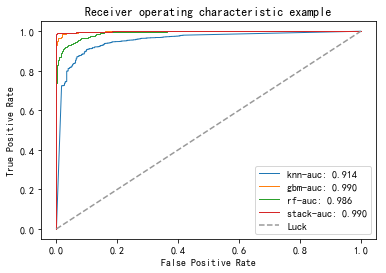

In [94]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

knn_prob = best_knn.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, knn_prob[:, 1])
roc_auc = auc(fpr, tpr)  # 求auc面积
plt.plot(fpr, tpr, lw=1, label='knn-auc: 0.914')    # 画出当前分割数据的ROC曲线

rf_prob = best_rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, rf_prob[:, 1])
roc_auc = auc(fpr, tpr)  # 求auc面积
plt.plot(fpr, tpr, lw=1, label='gbm-auc: 0.990')    # 画出当前分割数据的ROC曲线

stack_prob = best_stack.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, stack_prob[:, 1])
roc_auc = auc(fpr, tpr)  # 求auc面积
plt.plot(fpr, tpr, lw=1, label='rf-auc: 0.986')    # 画出当前分割数据的ROC曲线

gbm_prob = best_GBM.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, gbm_prob[:, 1])
roc_auc = auc(fpr, tpr)  # 求auc面积
plt.plot(fpr, tpr, lw=1, label='stack-auc: 0.990')    # 画出当前分割数据的ROC曲线

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck') # 画对角线
plt.xlim([-0.05, 1.05])     # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    # 可以使用中文，但需要导入一些库即字体
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

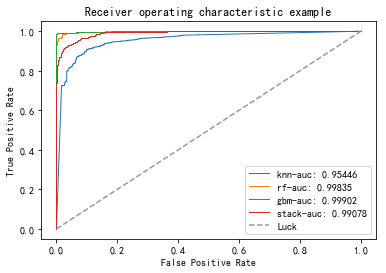

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

knn_prob = best_knn.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, knn_prob[:, 1])
roc_auc = auc(fpr, tpr)  # 求auc面积
plt.plot(fpr, tpr, lw=1, label='knn-auc: %0.5f' % roc_auc)    # 画出当前分割数据的ROC曲线

rf_prob = best_rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, rf_prob[:, 1])
roc_auc = auc(fpr, tpr)  # 求auc面积
plt.plot(fpr, tpr, lw=1, label='rf-auc: %0.5f' % roc_auc)    # 画出当前分割数据的ROC曲线

gbm_prob = best_GBM.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, gbm_prob[:, 1])
roc_auc = auc(fpr, tpr)  # 求auc面积
plt.plot(fpr, tpr, lw=1, label='gbm-auc: %0.5f' % roc_auc)    # 画出当前分割数据的ROC曲线

stack_prob = best_stack.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, stack_prob[:, 1])
roc_auc = auc(fpr, tpr)  # 求auc面积
plt.plot(fpr, tpr, lw=1, label='stack-auc: %0.5f' % roc_auc)    # 画出当前分割数据的ROC曲线

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck') # 画对角线
plt.xlim([-0.05, 1.05])     # 设置x、y轴的上下限，设置宽一点，以免和边缘重合，可以更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    # 可以使用中文，但需要导入一些库即字体
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

class binary_evaluation:
    """二分类模型评估类
    输入:
        y_true:一维np.array对象，实际值
        y_pred:一维np.array对象，预测概率
        precision:bool，True时cutoff阈值由预测概率逐一产生(速度慢，精度高)，False时cutoff阈值分段产生(速度快，精度低)，默认False
    方法：
        confusion_matrix(): 计算混淆矩阵的指标   
        threhold(): 产生cut-off阈值
        index(): 计算不同cut-off阈值下的指标
        plot_roc(): 绘制ROC曲线
        plot_gains(): 绘制收益曲线，常用于营销类二分类模型
        plot_lift(): 绘制提升曲线，常用于营销类二分类模型
        plot_lorenz(): 绘制洛伦兹曲线，常用于信用风险建模
        plot_ks(): 绘制ks曲线，常用于信用风险建模 
        plot_afdr_adr(): 绘制afdr_adr曲线，常用于欺诈侦测模型
        plot_precision_recall(): 绘制精准率-召回率曲线，功能与ROC曲线类似，但在样本不平衡时，ROC曲线更佳稳健                              
    """
    
    def __init__(self,y_true,y_pred,precision=False):
        
        self.true = y_true
        self.pred = y_pred
        self.precision = precision
        
    
    def confusion_matrix(self,pred):
        
        # 产生混淆矩阵的四个指标
        tn, fp, fn, tp = metrics.confusion_matrix(self.true,pred).ravel()
        
        # 产生衍生指标
        fpr = fp/(fp + tn) #假真率／特异度
        tpr = tp/(tp + fn) #灵敏度／召回率
        depth = (tp + fp)/(tn+fp+fn+tp) #Rate of positive predictions.
        ppv = tp/(tp + fp) #精准率
        lift = ppv/((tp + fn)/(tn+fp+fn+tp)) #提升度
        afdr = fp/tp #(虚报／命中)／好账户误判率
        return(fpr,tpr,depth,ppv,lift,afdr)


    def threhold(self):
       
        min_score = min(self.pred) #预测概率最大值
        max_score = max(self.pred) #预测概率最小值
        
         # 精度要求下产生分阈值
        if self.precision is True:
            thr = self.pred
        elif self.precision is False:
            thr = np.linspace(min_score, max_score,100)
        else:
            raise ValueError('precision should be True or False!')
        
        return(thr)

        
    def index(self):
        """计算不同cutoff下的相关统计量
        涉及统计量为：
            fpr: 假正率/特异度
            tpr: 真正率／灵敏度／召回率
            depth: 深度／响应率
            ppv: 精准率／命中率
            lift: 提升度
            afdr: 误判率
        """
        
        # 产生cutoff阈值 
        threhold = self.threhold()
        
        # 产生指标列表
        fpr_list = []
        tpr_list = []
        depth_list = []
        ppv_list = []
        lift_list = []
        afdr_list = []
        
        # 遍历每一个cutoff下的指标，并输出结果
        for i in threhold:
            
            # cutoff下产生0，1预测值
            pred = (self.pred > i).astype('int64')
            
            #产生指标
            fpr,tpr,depth,ppv,lift,afdr = self.confusion_matrix(pred = pred)
            
            #append指标                
            fpr_list.append(fpr)
            tpr_list.append(tpr)
            depth_list.append(depth)
            ppv_list.append(ppv)
            lift_list.append(lift)
            afdr_list.append(afdr)
            
        return(fpr_list,tpr_list,depth_list,ppv_list,lift_list,afdr_list)
 
        
    def plot_roc(self,color='red',legend='model',title='Roc_Curve',xlabel='FPR',ylabel='TPR'):
        """绘制ROC曲线
        X轴 : fpr 
        Y轴 : tpr
        参数 :
            color: 颜色
            legend: 图例名
            title: 标题
            xlabel: x轴标签
            ylabel: y轴标签
        """
        
        # 计算auc
        auc = round(metrics.roc_auc_score(self.true,self.pred),2) 
            
        # 计算fpr(x轴)和tpr(y轴)
        fpr,tpr,_,_,_,_ = self.index()       
        
        #绘图
        plt.plot(fpr,tpr,
                 color = color,
                 label = legend + ' auc: {}'.format(auc),
                 linestyle = '-')

        plt.plot([0,1],[0,1],
                 color = 'black',
                 linestyle = '--')    

        plt.title(title)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        plt.legend(loc=4)
        
    
    def plot_gains(self,color='red',legend='model',title='Gain_Curve',xlabel='Depth/RPP',ylabel='ppv'):
        """绘制增益曲线，该曲线常用于营销类模型
        X轴 : depth
        Y轴 : ppv
        参数 :
            color: 颜色
            legend: 图例名
            title: 标题
            xlabel: x轴标签
            ylabel: y轴标签
        """  
        
        # 计算depth(x轴)和ppv(y轴)
        _,_,depth,ppv,_,_ = self.index()
        
        # 绘图
        plt.plot(depth,ppv,
                 color = color,
                 linestyle = '-',
                 label = legend)
        
        plt.title(title)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc=1)
        
        
    def plot_lift(self,color='red',legend='model',title='Lift_Curve',xlabel='Depth/RPP',ylabel='Lift'):
        """绘制提升曲线，该曲线常用于营销类模型
        X轴 : depth
        Y轴 : lift
        参数 :
            color: 颜色
            legend: 图例名
            title: 标题
            xlabel: x轴标签
            ylabel: y轴标签
        """    
        
        # 计算depth(x轴)和lift(y轴)
        _,_,depth,_,lift,_ = self.index()
        
        # 绘图
        plt.plot(depth,lift,
                 color = color,
                 linestyle = '-',
                 label = legend)

        plt.title(title)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc=1)    
        
        
    def plot_lorenz(self,color='red',legend='model',title='Lorenz_Curve',xlabel='Depth/RPP',ylabel='True Postive Rate'):
        """绘制洛伦兹曲线，该曲线常用于信用风险建模
        X轴 : depth
        Y轴 : tpr
        参数 :
            color: 颜色
            legend: 图例名
            title: 标题
            xlabel: x轴标签
            ylabel: y轴标签
        """  
        
        # 计算depth(x轴)和tpr(y轴)
        _,tpr,depth,_,_,_ = self.index()
        
        #绘图
        plt.plot(depth,tpr,
                 color = color,
                 linestyle = '-',
                 label = legend)
        
        plt.plot([0,1],[0,1],
                 color = 'black',
                 linestyle = '--') 

        plt.title(title)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc=4)

        
    def plot_ks(self,color='red',legend='model',title='KS_Curve',xlabel='Depth/RPP',ylabel='KS statistic'):
        """绘制KS曲线，该曲线常用于信用风险建模
        X轴 : depth
        Y轴 : ks
        参数 :
            color: 颜色
            legend: 图例名
            title: 标题
            xlabel: x轴标签
            ylabel: y轴标签
        """
        
        # 计算depth(x轴)和fpr,tpr(y轴)
        fpr,tpr,depth,_,_,_ = self.index()
        ks = np.array(tpr) - np.array(fpr)
        ks_stats = round(max(ks),2) * 100
        
        #绘图            
        plt.plot(depth,ks,
                 color = color,
                 linestyle = '-',
                 label = legend + ' KS : {}'.format(ks_stats))

        plt.title(title)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)        
        plt.legend(loc=3)
        
        
    def plot_afdr_adr(self,color='red',legend='model',xlabel='afdr',ylabel='recall',title='AFDR_ADR_Curve'):
        """绘制afdr_adr曲线,该曲线常用于欺诈侦测模型
        X轴 : afdr
        Y轴 : adr／tpr/RECALL
        参数 :
            color: 颜色
            legend: 图例名
            title: 标题
            xlabel: x轴标签
            ylabel: y轴标签
        """
        
        # 计算afdr(x轴)和adr(y轴)
        _,tpr,_,_,_,afdr = self.index()
        
        #绘图       
        plt.plot(afdr,tpr,
                 color = color,
                 linestyle = '-',
                 label = legend)

        plt.title(title)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc=4)        

        
    def plot_precision_recall(self,color='red',legend='model',xlabel='recall',ylabel='precision',title='Precision_Recall_Curve'):
        """绘制precision_recall曲线,该曲线功能类似于ROC，但样本不平衡时ROC曲线更佳稳健
        X轴 : tpr/recall
        Y轴 : ppv
        参数 :
            color: 颜色
            legend: 图例名
            title: 标题
            xlabel: x轴标签
            ylabel: y轴标签
        """     
        
        # 计算fpr(x轴)和ppv(y轴)
        _,tpr,_,ppv,_,_ = self.index()
        
        #绘图      
        plt.plot(tpr,ppv,
                 color = color,
                 linestyle = '-',
                 label = legend)

        plt.title(title)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc=3)    

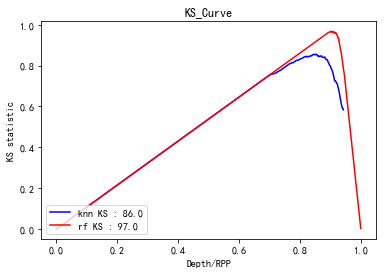

In [55]:
binary_evaluation(y_true=y_test, y_pred=knn_prob[:,1] ).plot_ks(color='blue',legend='knn')
binary_evaluation(y_true=y_test, y_pred=rf_prob[:,1] ).plot_ks(color='red',legend='rf')

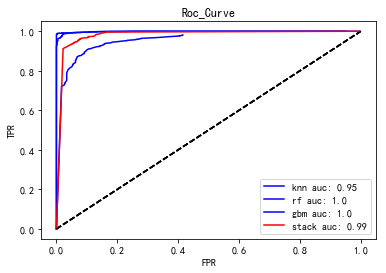

In [89]:
binary_evaluation(y_true=y_test, y_pred=knn_prob[:,1] ).plot_roc(color='blue',legend='knn')
binary_evaluation(y_true=y_test, y_pred=rf_prob[:,1] ).plot_roc(color='blue',legend='rf')
binary_evaluation(y_true=y_test, y_pred=gbm_prob[:,1] ).plot_roc(color='blue',legend='gbm')
binary_evaluation(y_true=y_test, y_pred=stack_prob[:,1] ).plot_roc(color='red',legend='stack')

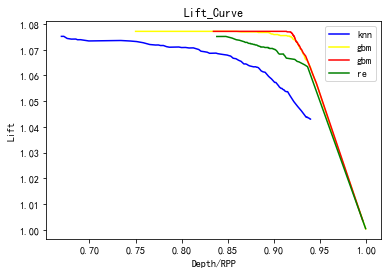

In [98]:
binary_evaluation(y_true=y_test, y_pred=knn_prob[:,1] ).plot_lift(color='blue',legend='knn')
binary_evaluation(y_true=y_test, y_pred=rf_prob[:,1] ).plot_lift(color='yellow',legend='gbm')
binary_evaluation(y_true=y_test, y_pred=gbm_prob[:,1] ).plot_lift(color='red',legend='gbm')
binary_evaluation(y_true=y_test, y_pred=stack_prob[:,1] ).plot_lift(color='green',legend='re')